# Text-to-Music generation using Riffusion and OpenVINO

[Riffusion](https://huggingface.co/riffusion/riffusion-model-v1) is a latent text-to-image diffusion model capable of generating spectrogram images given any text input. These spectrograms can be converted into audio clips.
General diffusion models are machine learning systems that are trained to denoise random Gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have been shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference. OpenVINO brings capabilities to run model inference on Intel hardware and opens the door to the fantastic world of diffusion models for everyone!

In this tutorial, we consider how to run a text-to-music generation pipeline using Riffusion and OpenVINO. We will use a pre-trained model from the [Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format.

The tutorial consists of the following steps:

- Install prerequisites
- Download and convert the model from a public source using the [OpenVINO integration with Hugging Face Optimum](https://huggingface.co/blog/openvino).
- Create a text-to-music inference pipeline
- Run inference pipeline

## About Riffusion

Riffusion is based on Stable Diffusion v1.5 and fine-tuned on images of spectrograms paired with text. Audio processing happens downstream of the model. This model can generate an audio spectrogram for given input text.

An audio spectrogram is a visual way to represent the frequency content of a sound clip. The x-axis represents time, and the y-axis represents frequency. The color of each pixel gives the amplitude of the audio at the frequency and time given by its row and column.
An audio [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) is a visual way to represent the frequency content of a sound clip. The x-axis represents time, and the y-axis represents frequency. The color of each pixel gives the amplitude of the audio at the frequency and time given by its row and column.

![spectrogram.png]()
<img src="https://www.riffusion.com/_next/image?url=%2F_next%2Fstatic%2Fmedia%2Fspectrogram_label.8c8aea56.png&w=1920&q=75" alt="spectrogram" style="width: 40%; height: 40%"/>


*[*image source](https://www.riffusion.com/about)*

The spectrogram can be computed from audio using the [Short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform), which approximates the audio as a combination of sine waves of varying amplitudes and phases.

![stft.png](https://www.riffusion.com/_next/image?url=%2F_next%2Fstatic%2Fmedia%2Ffourier_transform.9d53f3d7.png&w=640&q=75)

*[*image source](https://www.riffusion.com/about)*

The STFT is invertible, so the original audio can be reconstructed from a spectrogram. This idea is a behind approach to using Riffusion for audio generation.

## Prerequisites

In [1]:
!pip install -q "diffusers>=0.16.1" "transformers>=4.28.0"
!pip install -q "git+https://github.com/huggingface/optimum-intel.git" onnx onnxruntime "gradio>=3.34.0"


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys

if sys.platform == "darwin":
    !pip install -q "torchaudio==0.13.1" --find-links https://download.pytorch.org/whl/torch_stable.html
else:
    !pip install -q "torchaudio==0.13.1+cpu" --find-links https://download.pytorch.org/whl/torch_stable.html


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: pip install --upgrade pip


## Stable Diffusion pipeline in Optimum Intel

As the riffusion model architecture is the same as Stable Diffusion, we can use it with the Stable Diffusion pipeline for text-to-image generation.
[Optimum Intel](https://huggingface.co/docs/optimum/intel/inference) can be used to load optimized models from the Hugging Face Hub and create pipelines to run an inference with OpenVINO Runtime without rewriting APIs.
When Stable Diffusion models are exported to the OpenVINO format, they are decomposed into three components that consist of four models combined during inference into the pipeline:

* The text encoder
* The U-NET
* The VAE encoder
* The VAE decoder

More details about the Stable Diffusion pipeline can be found in [stable-diffusion](../225-stable-diffusion-text-to-image/225-stable-diffusion-text-to-image.ipynb) notebook.

For running the Stable Diffusion model with Optimum Intel, we should use the `optimum.intel.OVStableDiffusionPipeline` class, which represents the inference pipeline. `OVStableDiffusionPipeline` initialized by the `from_pretrained` method. It supports on-the-fly conversion models from PyTorch using the `export=True` parameter. A converted model can be saved on disk using the `save_pretrained` method for the next running.

In [3]:
from pathlib import Path

MODEL_ID = "riffusion/riffusion-model-v1"
MODEL_DIR = Path("riffusion_pipeline")

### Select inference device

select device from dropdown list for running inference using OpenVINO

In [4]:
import ipywidgets as widgets
from openvino.runtime import Core

core = Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [5]:
from optimum.intel.openvino import OVStableDiffusionPipeline

DEVICE = device.value

if not MODEL_DIR.exists():
    pipe = OVStableDiffusionPipeline.from_pretrained(MODEL_ID, export=True, device=DEVICE, compile=False)
    pipe.half()
    pipe.save_pretrained(MODEL_DIR)
else:
    pipe = OVStableDiffusionPipeline.from_pretrained(MODEL_DIR, device=DEVICE, compile=False)

2023-07-17 16:22:33.905103: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-17 16:22:33.943298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 16:22:34.567997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
comet_ml is installed but `COMET_API_KEY` is not set.


Framework not specified. Using pt to export to ONNX.
unet/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Keyword arguments {'subfolder': '', 'config': {'_class_name': 'StableDiffusionPipeline', '_diffusers_version': '0.4.0', 'feature_extractor': ['transformers', 'CLIPImageProcessor'], 'safety_checker': ['stable_diffusion', 'StableDiffusionSafetyChecker'], 'scheduler': ['diffusers', 'PNDMScheduler'], 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer'], 'unet': ['diffusers', 'UNet2DConditionModel'], 'vae': ['diffusers', 'AutoencoderKL']}} are not expected by StableDiffusionPipeline and will be ignored.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ea/work/notebooks_convert/notebooks_conv_env/lib/python3.8/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:181: FutureWarning: The configuration file of the unet has set the default `sample_size` to smaller than 64 which seems highly unlikely. If your checkpoint is a fine-tun

## Prepare postprocessing for reconstruction audio from spectrogram image

The riffusion model generates an audio spectrogram image, which can be used to reconstruct audio. However, the spectrogram images from the model only contain the amplitude of the sine waves and not the phases, because the phases are chaotic and hard to learn. Instead, we can use the [Griffin-Lim](https://ieeexplore.ieee.org/document/1164317) algorithm to approximate the phase when reconstructing the audio clip. The Griffin-Lim Algorithm (GLA) is a phase reconstruction method based on the redundancy of the [Short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform). It promotes the consistency of a spectrogram by iterating two projections, where a spectrogram is said to be consistent when its inter-bin dependency owing to the redundancy of STFT is retained. GLA is based only on consistency and does not take any prior knowledge about the target signal into account. 

The frequency bins in generated spectrogram use the [Mel scale](https://en.wikipedia.org/wiki/Mel_scale), which is a perceptual scale of pitches judged by listeners to be equal in distance from one another.

The code below defines the process of reconstruction of a WAV audio clip from a spectrogram image using Griffin-Lim Algorithm.

In [6]:
import io
from typing import Tuple

import numpy as np
from PIL import Image
from scipy.io import wavfile
import torch
import torchaudio


def wav_bytes_from_spectrogram_image(image: Image.Image) -> Tuple[io.BytesIO, float]:
    """
    Reconstruct a WAV audio clip from a spectrogram image. Also returns the duration in seconds.
    
    Parameters:
      image (Image.Image): generated spectrogram image
    Returns:
      wav_bytes (io.BytesIO): audio signal encoded in wav bytes
      duration_s (float): duration in seconds
    """

    max_volume = 50
    power_for_image = 0.25
    Sxx = spectrogram_from_image(image, max_volume=max_volume, power_for_image=power_for_image)

    sample_rate = 44100  # [Hz]
    clip_duration_ms = 5000  # [ms]

    bins_per_image = 512
    n_mels = 512

    # FFT parameters
    window_duration_ms = 100  # [ms]
    padded_duration_ms = 400  # [ms]
    step_size_ms = 10  # [ms]

    # Derived parameters
    num_samples = int(image.width / float(bins_per_image) * clip_duration_ms) * sample_rate
    n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
    hop_length = int(step_size_ms / 1000.0 * sample_rate)
    win_length = int(window_duration_ms / 1000.0 * sample_rate)

    samples = waveform_from_spectrogram(
        Sxx=Sxx,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        num_samples=num_samples,
        sample_rate=sample_rate,
        mel_scale=True,
        n_mels=n_mels,
        max_mel_iters=200,
        num_griffin_lim_iters=32,
    )

    wav_bytes = io.BytesIO()
    wavfile.write(wav_bytes, sample_rate, samples.astype(np.int16))
    wav_bytes.seek(0)

    duration_s = float(len(samples)) / sample_rate

    return wav_bytes, duration_s


def spectrogram_from_image(
    image: Image.Image, max_volume: float = 50, power_for_image: float = 0.25
) -> np.ndarray:
    """
    Compute a spectrogram magnitude array from a spectrogram image.
    
    Parameters:
      image (image.Image): input image
      max_volume (float, *optional*, 50): max volume for spectrogram magnitude
      power_for_image (float, *optional*, 0.25): power for reversing power curve
    """
    # Convert to a numpy array of floats
    data = np.array(image).astype(np.float32)

    # Flip Y take a single channel
    data = data[::-1, :, 0]

    # Invert
    data = 255 - data

    # Rescale to max volume
    data = data * max_volume / 255

    # Reverse the power curve
    data = np.power(data, 1 / power_for_image)

    return data


def waveform_from_spectrogram(
    Sxx: np.ndarray,
    n_fft: int,
    hop_length: int,
    win_length: int,
    num_samples: int,
    sample_rate: int,
    mel_scale: bool = True,
    n_mels: int = 512,
    max_mel_iters: int = 200,
    num_griffin_lim_iters: int = 32,
    device: str = "cpu",
) -> np.ndarray:
    """
    Reconstruct a waveform from a spectrogram.
    This is an approximate waveform, using the Griffin-Lim algorithm
    to approximate the phase.
    """
    Sxx_torch = torch.from_numpy(Sxx).to(device)

    if mel_scale:
        mel_inv_scaler = torchaudio.transforms.InverseMelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
            max_iter=max_mel_iters,
        ).to(device)

        Sxx_torch = mel_inv_scaler(Sxx_torch)

    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=1.0,
        n_iter=num_griffin_lim_iters,
    ).to(device)

    waveform = griffin_lim(Sxx_torch).cpu().numpy()

    return waveform

## Run Inference pipeline

The diagram below briefly describes the workflow of our pipeline

![riffusion_pipeline.png](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/3de12c6b-23ef-4953-aeda-5785108990b9)

As you can see, it is very similar to Stable Diffusion Text-to-Image generation with an additional post-processing step that transforms generated spectrogram into an audio signal. Firstly, `OVStableDiffusionPipeline` accepts input text prompt, which will be tokenized and transformed to embeddings space using Frozen CLIP text encoder and generates initial latent spectrogram representation using a random generator, then U-Net iteratively *denoises* the random latent spectrogram image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. The *denoising* process is repeated a given number of times (by default 50) to step-by-step retrieve better latent image representations. When complete, the latent image representation is decoded by the decoder part of the variational auto-encoder. Generated spectrogram image will be converted into a spectrogram magnitude range and inverse mel scale applied to it to estimate an STFT in the normal frequency domain from the mel frequency domain. Finally, Griffin-Lim Algorithm approximates the phase of an audio signal and we got reconstructed audio. 

In [7]:
pipe.reshape(batch_size=1, height=512, width=512, num_images_per_prompt=1)
pipe.compile()

def generate(prompt:str, negative_prompt:str = "") -> Tuple[Image.Image, str]:
    """
    function for generation audio from text prompt
    
    Parameters:
      prompt (str): input prompt for generation.
      negative_prompt (str): negative prompt for generation, contains undesired concepts for generation, which should be avoided. Can be empty.
    Returns:
      spec (Image.Image) - generated spectrogram image
    """
    spec = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=20).images[0]
    wav = wav_bytes_from_spectrogram_image(spec)
    with open("output.wav", "wb") as f:
        f.write(wav[0].getbuffer())
    return spec, "output.wav"

Compiling the text_encoder...
Compiling the vae_decoder...
Compiling the unet...


Now, we can test our generation. Function generate accepts text input and returns generated spectrogram and path to generated audio. Optionally, it also accepts negative prompt. A negative prompt declares undesired concepts for generation, e.g. if we want to generate instrumental music, having vocal on audio will be an unwanted effect, so in this case vocal can be treated as a negative prompt. The positive and negative prompts are in equal footing. You can always use one with or without the other. More explanation of how it works can be found in this [article](https://stable-diffusion-art.com/how-negative-prompt-work/). 

In [8]:
spectrogram, wav_path = generate("Techno beat")

  0%|          | 0/21 [00:00<?, ?it/s]

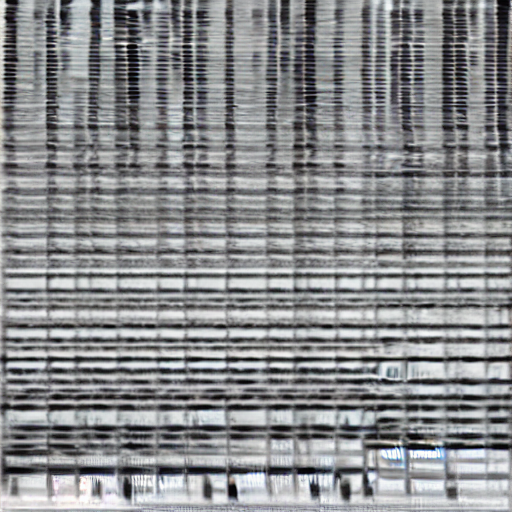

In [9]:
spectrogram

In [10]:
import IPython.display as ipd
ipd.Audio(wav_path)

## Interactive demo

In [11]:
import gradio as gr
from openvino.runtime import Core

available_devices = Core().available_devices + ["AUTO"]

examples = [
    "acoustic folk violin jam",
    "bossa nova with distorted guitar",
    "arabic gospel vocals",
    "piano funk",
    "swing jazz trumpet",
    "jamaican dancehall vocals",
    "ibiza at 3am",
    "k-pop boy group",
    "laughing",
    "water drops"
]

def select_device(device_str:str, current_text:str = "", progress:gr.Progress = gr.Progress()):
    """
    Helper function for uploading model on the device.
    
    Parameters:
      device_str (str): Device name.
      current_text (str): Current content of user instruction field (used only for backup purposes, temporally replacing it on the progress bar during model loading).
      progress (gr.Progress): gradio progress tracker
    Returns:
      current_text
    """
    if device_str != pipe._device:
        pipe.clear_requests()
        pipe.to(device_str)
        
        for i in progress.tqdm(range(1), desc=f"Model loading on {device_str}"):
            pipe.compile()
    return current_text

with gr.Blocks() as demo:
    
    with gr.Column():
        gr.Markdown(
            "# Riffusion music generation with OpenVINO\n"
            " Describe a musical prompt, generate music by getting a spectrogram image and sound."
        )
        
        prompt_input = gr.Textbox(placeholder="", label="Musical prompt")
        negative_prompt = gr.Textbox(label="Negative prompt")
        device = gr.Dropdown(choices=available_devices, value=DEVICE, label="Device")
            
        send_btn = gr.Button(value="Get a new spectrogram!")
        gr.Examples(examples, prompt_input, examples_per_page=15)
            
    with gr.Column():
        sound_output = gr.Audio(type='filepath', label="spectrogram sound")
        spectrogram_output = gr.Image(label="spectrogram image result")
        spectrogram_output.style(height=256)
    
    send_btn.click(generate, inputs=[prompt_input, negative_prompt], outputs=[spectrogram_output, sound_output])
    device.change(select_device, [device, prompt_input], [prompt_input])

if __name__ == "__main__":
    try:
        demo.launch(enable_queue=True, height=800)
    except Exception:
        demo.launch(enable_queue=True, share=True, height=800)

/tmp/ipykernel_1282292/2438576232.py:56: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  spectrogram_output.style(height=256)
/tmp/ipykernel_1282292/2438576232.py:63: GradioDeprecationWarning: The `enable_queue` parameter has been deprecated. Please use the `.queue()` method instead.
  demo.launch(enable_queue=True, height=800)


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
